## Importing libraries and VGG CNN model

In [3]:
from tensorflow.keras.applications import VGG16

#VGG 16 was designed to work on 224x224 pixel input image sizes
img_rows = 224
img_cols = 224

#Loads the VGG16 model
vgg16 = VGG16(weights='imagenet',include_top=False,input_shape=(img_rows,img_cols,3))

58892288/58889256 [==============================] - 10s 0us/step


## Inspecting each layer

In [5]:
for i,layer in enumerate(vgg16.layers):
    print(str(i)+" "+layer.__class__.__name__,layer.trainable)

0 InputLayer True
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


## Freezing all layers except top4

In [6]:
# Layers are set to trainable as True by default
for layer in vgg16.layers:
    layer.trainable = False
    
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


## Create Function to Define FC layers

In [7]:
def addTopModel(bottom_model,num_classes):
    """CREATES THE TOP OR HEAD OF THE MODEL THAT WILL BE
    PLACED ON TOP OF THE BOTTOM LAYERS"""
    top_model = bottom_model.output
    top_model = Flatten(name='flatten')(top_model)
    top_model = Dense(256,activation = 'relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes,activation = 'softmax')(top_model)
    return top_model

## FC Layers Creation

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model

Using TensorFlow backend.


In [9]:
num_classes = 17

FC_Head = addTopModel(vgg16,num_classes)

model = Model(inputs=vgg16.input,outputs=FC_Head)

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Data Preperation and Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = '17_flowers/train'
validation_data_dir = '17_flowers/validation'

train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range = 20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_batchsize = 16
val_batchsize = 10

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size=(img_rows,img_cols),
                                                   batch_size=train_batchsize,
                                                   class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                             target_size=(img_rows,img_cols),
                                                             batch_size=val_batchsize,
                                                             class_mode='categorical',
                                                             shuffle=False)

Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


## Training

In [16]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint('flowers_vgg.h5',
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

#We put our call backs into a callback list
callbacks = [earlystop,checkpoint]

#Note we use a very small learning rate
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(lr=0.001),
             metrics=['accuracy'])

epochs = 5
batch_size = 16

history = model.fit(train_generator,
                   steps_per_epoch=1190//batch_size,
                   epochs=epochs,
                   callbacks=callbacks,
                   validation_data = validation_generator,
                   validation_steps=170//batch_size)

Epoch 1/5
74/74 [==============================] - ETA: 0s - loss: 4.2050 - accuracy: 0.1763
Epoch 00001: val_loss improved from inf to 1.90235, saving model to flowers_vgg.h5
74/74 [==============================] - 172s 2s/step - loss: 4.2050 - accuracy: 0.1763 - val_loss: 1.9024 - val_accuracy: 0.4900
Epoch 2/5
74/74 [==============================] - ETA: 0s - loss: 1.9910 - accuracy: 0.3731
Epoch 00002: val_loss improved from 1.90235 to 1.06151, saving model to flowers_vgg.h5
74/74 [==============================] - 172s 2s/step - loss: 1.9910 - accuracy: 0.3731 - val_loss: 1.0615 - val_accuracy: 0.6100
Epoch 3/5
74/74 [==============================] - ETA: 0s - loss: 1.5928 - accuracy: 0.4889
Epoch 00003: val_loss did not improve from 1.06151
74/74 [==============================] - 167s 2s/step - loss: 1.5928 - accuracy: 0.4889 - val_loss: 1.1630 - val_accuracy: 0.6800
Epoch 4/5
74/74 [==============================] - ETA: 0s - loss: 1.3780 - accuracy: 0.5843
Epoch 00004: val_

## Result

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

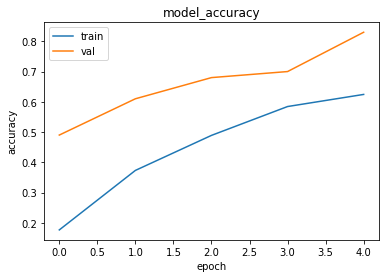

In [19]:
losses = history.history['accuracy']
val_losses = history.history['val_accuracy']
plt.plot(losses)
plt.plot(val_losses)
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='best')

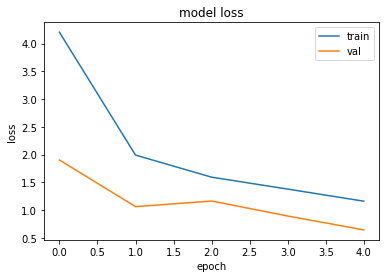

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

## Prediction and Evaluation

In [23]:
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np

In [26]:
y_pred = model.predict(validation_generator)
y_pred_true = np.argmax(y_pred,axis=1)
label_map = (train_generator.class_indices)

In [27]:
print(classification_report(validation_generator.classes,y_pred_true,target_names=label_map.keys()))

              precision    recall  f1-score   support

    bluebell       0.83      0.50      0.62        10
   buttercup       0.90      0.90      0.90        10
  colts_foot       0.77      1.00      0.87        10
     cowslip       1.00      0.30      0.46        10
      crocus       0.69      0.90      0.78        10
    daffodil       0.77      1.00      0.87        10
       daisy       1.00      1.00      1.00        10
   dandelion       1.00      0.70      0.82        10
  fritillary       0.71      1.00      0.83        10
        iris       0.91      1.00      0.95        10
 lily_valley       1.00      0.50      0.67        10
       pansy       0.83      1.00      0.91        10
    snowdrop       0.90      0.90      0.90        10
   sunflower       1.00      1.00      1.00        10
   tigerlily       1.00      0.90      0.95        10
       tulip       0.73      0.80      0.76        10
  windflower       0.77      1.00      0.87        10

    accuracy              

In [28]:
df_cm = pd.DataFrame(confusion_matrix(validation_generator.classes,y_pred_true),label_map.keys(),label_map.keys())

Text(194.09375, 0.5, 'label (ground truth)')

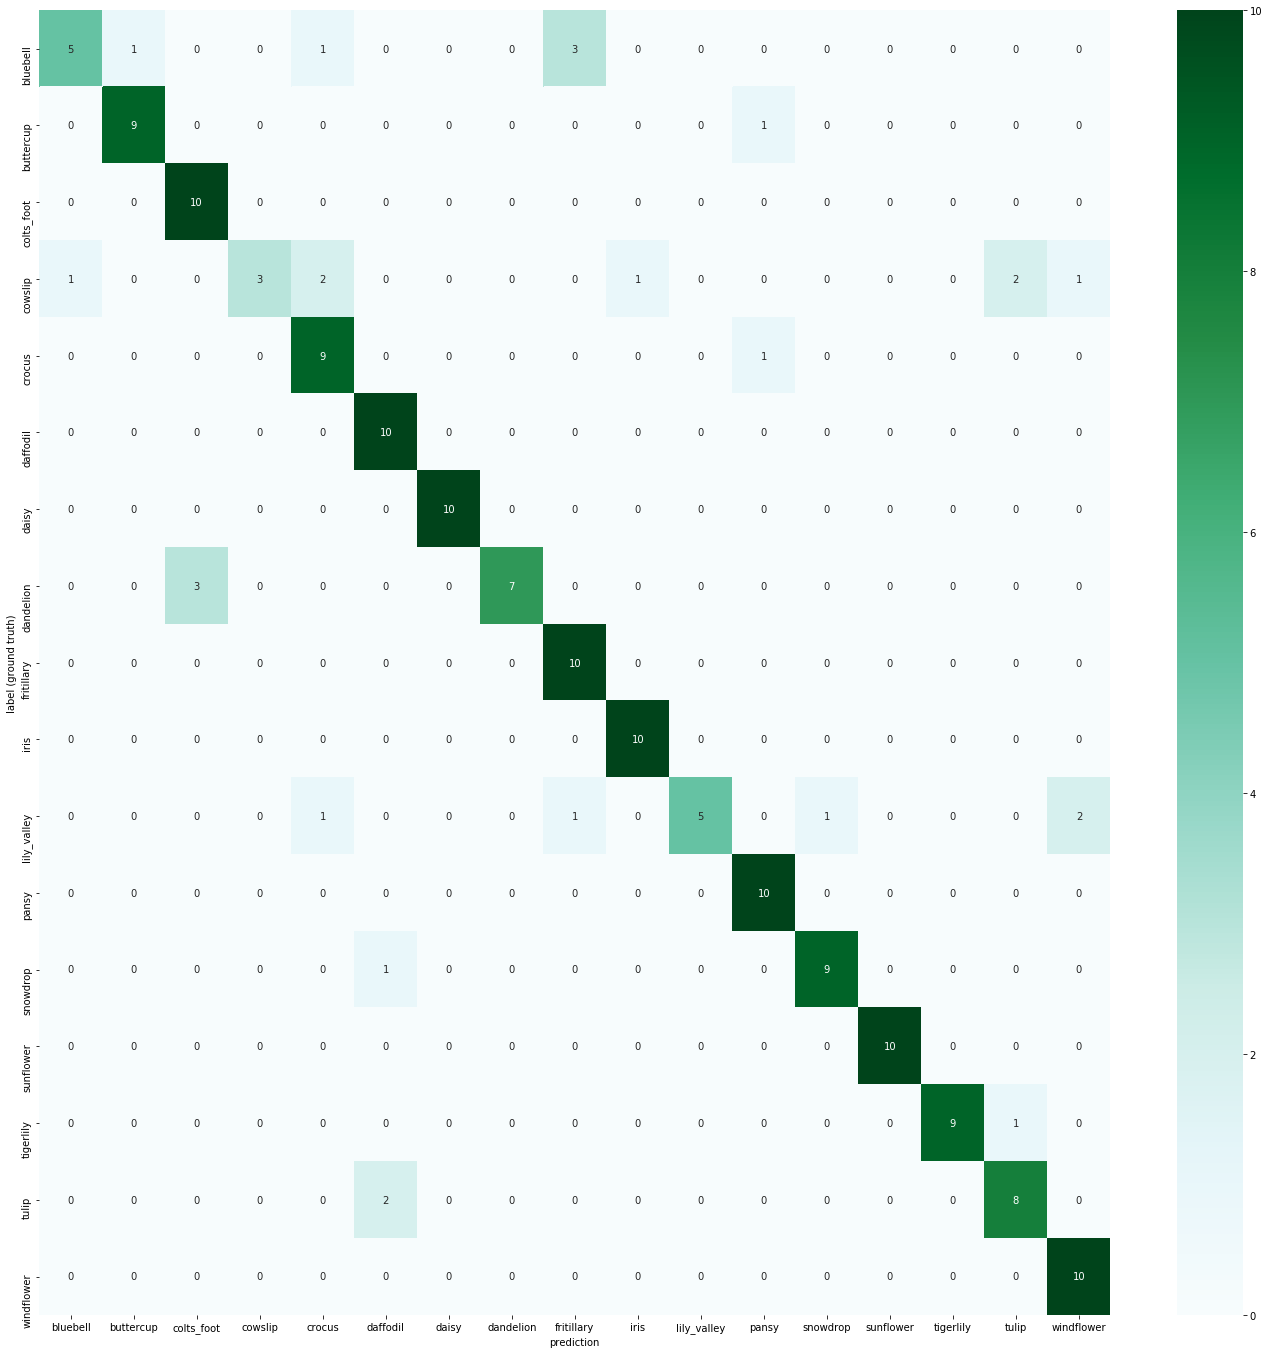

In [29]:
#print('Confusion Matrix')
#print(confusion_matrix(validation_generator.classes,y_pred))
plt.figure(figsize=(24,24))
sns.heatmap(df_cm,annot=True,cmap='BuGn',fmt="d")
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")